In [28]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

# Carga de datos

In [29]:
# Load dataset
data = pd.read_csv('Maternal Health Risk Data Set.csv')
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


# Map 'RiskLevel' to numerical values
data['RiskLevel'] = data['RiskLevel'].map({'low risk': 0, 'mid risk': 1, 'high risk': 2})

# FEATURE ENGINEERING
# Direct relationships
data['PulsePressure'] = data['SystolicBP'] - data['DiastolicBP']

data['MAP'] = data['DiastolicBP'] + (data['PulsePressure'] / 3)

data['BPRatio'] = data['SystolicBP'] / data['DiastolicBP']

data['HRxSBP'] = data['HeartRate'] * data['SystolicBP']
data['HRxDBP'] = data['HeartRate'] * data['DiastolicBP']
data['HRxMAP'] = data['HeartRate'] * data['MAP']

data['Temp_HR'] = data['BodyTemp'] * data['HeartRate']

data['SBP/Age'] = data['SystolicBP'] / data['Age']
data['DBP/Age'] = data['DiastolicBP'] / data['Age']
data['BS/Age'] = data['BS'] / data['Age']

# Dummies
data['is_fever'] = (data['BodyTemp'] >= 100.4).astype(int)

# One-hot encoding Bins
data['Age_bin'] = pd.cut(
    data['Age'],
    bins=[0, 30, 50, np.inf],
    labels=['young', 'mid_age', 'senior'],
    right=True
)

def bp_category(row):
    sbp = row['SystolicBP']
    dbp = row['DiastolicBP']

    if sbp < 120 and dbp < 80:
        return 'normal'
    elif 120 <= sbp < 130 and dbp < 80:
        return 'elevated'
    elif (130 <= sbp < 140) or (80 <= dbp < 90):
        return 'stage1'
    elif sbp >= 140 or dbp >= 90:
        return 'stage2'
    else:
        return 'unknown'

data['BP_bin'] = data.apply(bp_category, axis=1)

# one-hot encoding
data = pd.get_dummies(
    data,
    columns=['Age_bin', 'BP_bin'],
    drop_first=False   # keeps all categories
)

# Drop less relevant features
data.drop(columns=(['HeartRate', 'DiastolicBP', 'SystolicBP']), inplace=True)

# Prepare data for training
x = data.drop(columns=['RiskLevel'])
y = data['RiskLevel']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=10)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Visualize data
x

In [30]:
data['RiskLevel'] = data['RiskLevel'].map({'low risk': 0, 'mid risk': 1, 'high risk': 2})
data['PulsePressure'] = data['SystolicBP'] - data['DiastolicBP']
data['MAP'] = data['DiastolicBP'] + (data['PulsePressure'] / 3)
data['BPRatio'] = data['SystolicBP'] / data['DiastolicBP']
data.drop(columns=(['HeartRate', 'DiastolicBP']), inplace=True)


x = data.drop(columns=['RiskLevel'])
y = data['RiskLevel']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=10)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

classes = np.unique(y_train)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights = dict(zip(classes, class_weights_array))

model = tf.keras.Sequential([

    tf.keras.layers.Dense(256, activation='relu',input_shape=(x_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=50,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    epochs=400,
    batch_size=32,
    validation_data=(x_test, y_test),
    class_weight=class_weights,
    verbose=0,
    callbacks=[early_stop]
)

y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

y_pred_train_classes = np.argmax(y_pred_train, axis=1)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)


Class Weights: {np.int64(0): np.float64(0.8223495702005731), np.int64(1): np.float64(1.0177304964539007), np.int64(2): np.float64(1.2478260869565216)}


/Users/sofia/Desktop/séptimo/ProyectoFinalMIA/venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


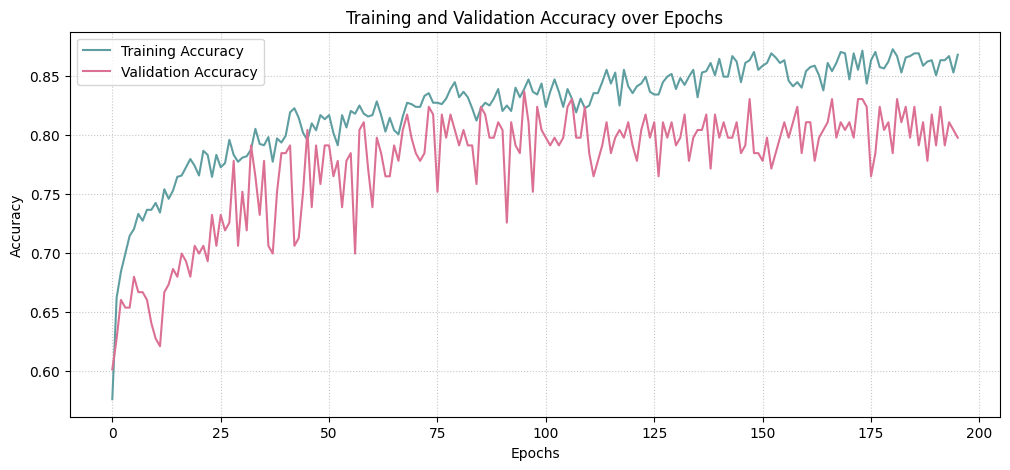

In [31]:
classes = np.unique(y_train)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights = dict(zip(classes, class_weights_array))
print("Class Weights:", class_weights)

model = tf.keras.Sequential([

    # Layer 1
    tf.keras.layers.Dense(
        128, activation='relu',
        input_shape=(x_train.shape[1],),
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.2),

    # Layer 2
    tf.keras.layers.Dense(
        32, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.2),

    # Layer 3
    tf.keras.layers.Dense(
        32, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),

    # Layer 4
    tf.keras.layers.Dense(
        64, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),

    # Layer 5
    tf.keras.layers.Dense(
        32, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=100,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(x_test, y_test),
    #class_weight=class_weights,
    callbacks=[early_stop],
    verbose=0
)

y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

y_pred_train_classes = np.argmax(y_pred_train, axis=1)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='cadetblue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='palevioletred')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.grid(linestyle=':', alpha=0.7)
plt.show()

In [32]:
y_new_pred_train = model.predict(x_train)
y_new_pred_test = model.predict(x_test)
y_new_pred_train_classes = np.argmax(y_new_pred_train, axis=1)
y_new_pred_test_classes = np.argmax(y_new_pred_test, axis=1)

A = confusion_matrix(y_train, y_new_pred_train_classes)
num_classes = A.shape[0]

TP = np.diag(A)
FP = np.sum(A, axis=0) - TP
FN = np.sum(A, axis=1) - TP
TN = np.sum(A) - (TP + FP + FN)

# Precision: TP / (TP + FP)
precision_per_class = TP / (TP + FP + 1e-12)

# Recall: TP / (TP + FN)
recall_per_class = TP / (TP + FN + 1e-12)

# Accuracy
accuracy = np.sum(TP) / np.sum(A)

# Macro averages
precision_macro = np.mean(precision_per_class)
recall_macro = np.mean(recall_per_class)

print("\n=== TRAIN METRICS ===")
print("Accuracy:", accuracy)

print("\nPrecision per class:", precision_per_class)
print("Macro Precision:", precision_macro)

print("\nRecall per class:", recall_per_class)
print("Macro Recall:", recall_macro)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

=== TRAIN METRICS ===
Accuracy: 0.8710801393728222

Precision per class: [0.85135135 0.84765625 0.92765957]
Macro Precision: 0.8755557252731423

Recall per class: [0.9025788  0.76950355 0.94782609]
Macro Recall: 0.8733028098724692


In [33]:
A = confusion_matrix(y_test, y_new_pred_test_classes)
num_classes = A.shape[0]

TP = np.diag(A)
FP = np.sum(A, axis=0) - TP
FN = np.sum(A, axis=1) - TP
TN = np.sum(A) - (TP + FP + FN)

# Precision: TP / (TP + FP)
precision_per_class = TP / (TP + FP + 1e-12)

# Recall: TP / (TP + FN)
recall_per_class = TP / (TP + FN + 1e-12)

# Accuracy
accuracy = np.sum(TP) / np.sum(A)

# Macro averages
precision_macro = np.mean(precision_per_class)
recall_macro = np.mean(recall_per_class)

print("\n=== TEST METRICS ===")
print("Accuracy:", accuracy)

print("\nPrecision per class:", precision_per_class)
print("Macro Precision:", precision_macro)

print("\nRecall per class:", recall_per_class)
print("Macro Recall:", recall_macro)


=== TEST METRICS ===
Accuracy: 0.8366013071895425

Precision per class: [0.79310345 0.77586207 1.        ]
Macro Precision: 0.8563218390804416

Recall per class: [0.80701754 0.83333333 0.88095238]
Macro Recall: 0.8404344193817709


In [34]:
# model.save('maternal_health_risk_model.keras')

In [35]:
def permutation_importance(model, x_valid, y_valid, metric=accuracy_score):
    baseline = metric(y_valid, np.argmax(model.predict(x_valid), axis=1))
    importances = {}

    for i, col in enumerate(range(x_valid.shape[1])):
        x_temp = x_valid.copy()
        np.random.shuffle(x_temp[:, i]) 

        score = metric(y_valid, np.argmax(model.predict(x_temp), axis=1))
        importances[col] = baseline - score

    return importances
importances = permutation_importance(model, x_test, y_test)
sorted_importances = dict(sorted(importances.items(), key=lambda x: x[1], reverse=True))
sorted_importances

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


{2: 0.30718954248366015,
 0: 0.20915032679738566,
 4: 0.20261437908496738,
 6: 0.1960784313725491,
 1: 0.18300653594771243,
 5: 0.18300653594771243,
 3: 0.12418300653594772}

In [36]:
x_train_df = pd.DataFrame(x_train, columns=x.columns)
x_test_df = pd.DataFrame(x_test, columns=x.columns)

x_train_df['RiskLevel'] = y_train.values
x_test_df['RiskLevel'] = y_test.values

#x_train_df.to_csv('maternal_health_risk_train.csv', index=False)
#x_test_df.to_csv('maternal_health_risk_test.csv', index=False)